In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

buffer_dir = '/p/crash/amago-multi-car-20251202/multi-car-20251202_crash-v0_trial_0/buffer/protected'

print('Listing files in protected buffer directory:')
buffer_list = os.listdir(buffer_dir)

def get_starting_states(file_path):
    with np.load(file_path) as data:
        first_state = data['_OBS_KEY_observation'][0] # First observation
        num_cars = np.sum(first_state[:, 0])
        dist_to_cars = np.linalg.norm(first_state[0, 1:3] - first_state[1:int(num_cars), 1:3], axis=1)
        relative_velocities = first_state[1:int(num_cars), 3] - first_state[0, 3]
    ttc = dist_to_cars / np.maximum(relative_velocities, 1e-5)
    # Sort by distance to ego car
    sorted_indices = np.argsort(dist_to_cars)
    dist_to_cars = dist_to_cars[sorted_indices]
    relative_velocities = relative_velocities[sorted_indices]
    ttc = ttc[sorted_indices]
    stats = {
        'num_cars': int(num_cars),
        'dist_to_cars': dist_to_cars,
        'relative_velocities': relative_velocities,
        'ttc': ttc
    }
    return stats

episode_stats = []
for file_name in tqdm(buffer_list):
    file_path = os.path.join(buffer_dir, file_name)
    stats = get_starting_states(file_path)
    episode_stats.append(stats)



Listing files in protected buffer directory:


  2%|▏         | 27793/1394353 [07:27<6:06:24, 62.16it/s] 


KeyboardInterrupt: 

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

buffer_dir = '/p/crash/amago-multi-car-20251202/multi-car-20251202_crash-v0_trial_0/buffer/protected'

# 1. Define the worker function at the top level (required for multiprocessing)
def process_single_file(file_path):
    try:
        with np.load(file_path) as data:
            # Only load the specific key we need
            first_state = data['_OBS_KEY_observation'][0] 
            
            num_cars = np.sum(first_state[:, 0])
            # Use slicing to avoid copying massive arrays if possible, 
            # though numpy usually copies on advanced indexing anyway.
            # Safety check: ensure num_cars is valid index
            limit = int(num_cars)
            
            # Vectorized calculations
            # (Your original logic is already vectorized, which is good)
            dist_to_cars = np.linalg.norm(first_state[0, 1:3] - first_state[1:limit, 1:3], axis=1)
            relative_velocities = first_state[1:limit, 3] - first_state[0, 3]
            
            ttc = dist_to_cars / np.maximum(relative_velocities, 1e-5)

            # Sort
            sorted_indices = np.argsort(dist_to_cars)
            
            return {
                'num_cars': limit,
                'dist_to_cars': dist_to_cars[sorted_indices],
                'relative_velocities': relative_velocities[sorted_indices],
                'ttc': ttc[sorted_indices]
            }
    except Exception as e:
        # Handle corrupt files or empty arrays gracefully
        return None

In [2]:
print('Listing files in protected buffer directory...')
buffer_list = os.listdir(buffer_dir)

# Pre-calculate full paths to avoid doing it inside the worker
file_paths = [os.path.join(buffer_dir, f) for f in buffer_list]

# Use number of cores available
num_workers = cpu_count()
print(f"Processing with {num_workers} workers...")

episode_stats = []

# 2. Create the Pool
with Pool(num_workers) as p:
    # imap_unordered is generally faster if you don't care about the order 
    # of the results matching the order of the input list.
    # If you DO care about order, change to p.imap
    results = list(tqdm(p.imap(process_single_file, file_paths), total=len(file_paths)))

# Filter out any Nones from failed reads
episode_stats = [r for r in results if r is not None]

print(f"Done. Processed {len(episode_stats)} files.")

Listing files in protected buffer directory...
Processing with 20 workers...


100%|██████████| 1394353/1394353 [16:04<00:00, 1446.04it/s]


Done. Processed 1394353 files.


100%|██████████| 1394353/1394353 [00:01<00:00, 1071281.97it/s]
4it [00:06,  1.50s/it]


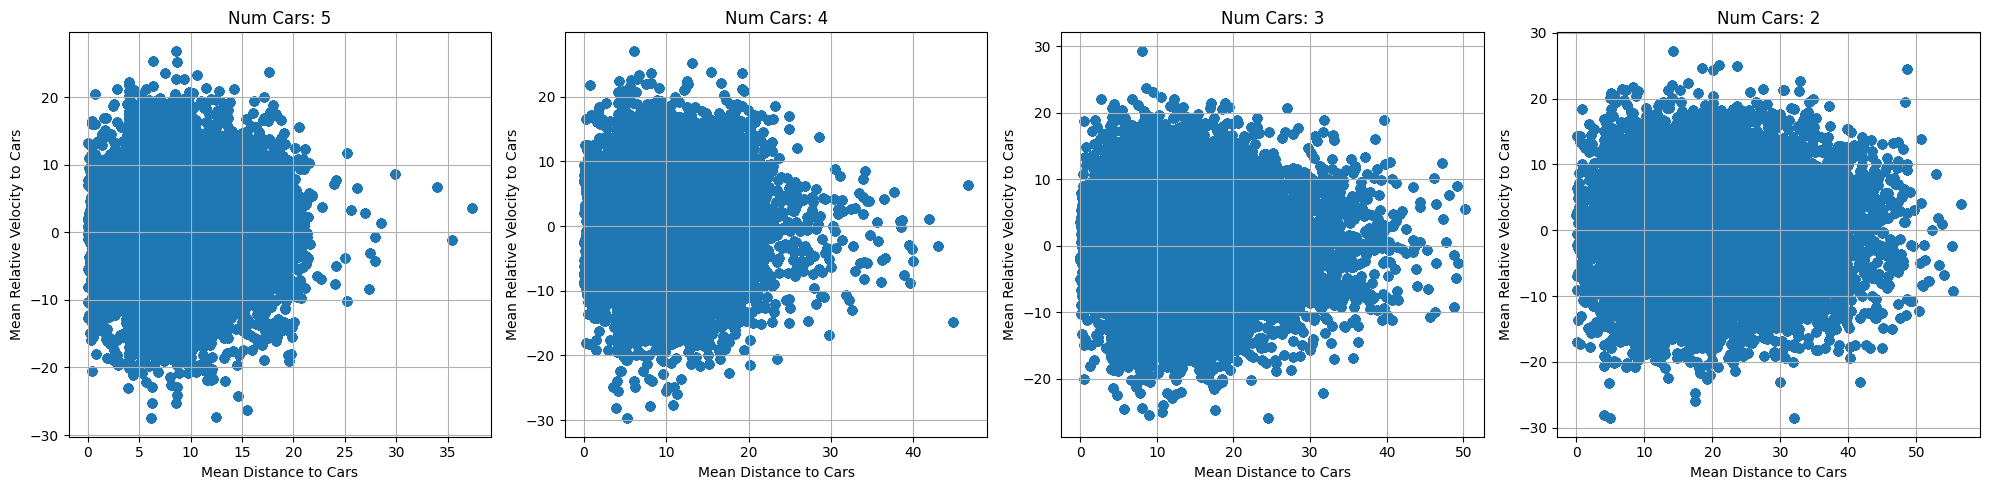

In [7]:
## Scatter Plots of Mean Relative Velocity vs Mean Distance per Car
mean_distances = {}
mean_relative_velocities = {}
for stats in tqdm(episode_stats):
    num_cars = stats['num_cars']
    if num_cars not in mean_distances:
        mean_distances[num_cars] = []
    mean_distances[num_cars].append(stats['dist_to_cars'][0])
    if num_cars not in mean_relative_velocities:
        mean_relative_velocities[num_cars] = []
    mean_relative_velocities[num_cars].append(stats['relative_velocities'][0])

fig, ax = plt.subplots(1, int(mean_distances.keys().__len__()), figsize=(5 * int(mean_distances.keys().__len__()), 5))
for i, k in tqdm(enumerate(mean_distances.keys())):
    ax[i].scatter(mean_distances[k], mean_relative_velocities[k])
    ax[i].set_title(f'Num Cars: {int(k)}')
    ax[i].set_xlabel('Mean Distance to Cars')
    ax[i].set_ylabel('Mean Relative Velocity to Cars')
    # ax[i].set_xlim(-10, 10)
    # ax[i].set_ylim(-25, 25)
    ax[i].grid(True)
plt.tight_layout()
plt.show()
    